In [1]:

import pandas as pd
import numpy as np
import pickle
import os
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import numpy as np

import time
from sklearn.metrics import accuracy_score, roc_auc_score
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sb
###
import pystan
from scipy.stats import pearsonr, zscore

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sb.set()

# Settings for Stan
Niters = 1000 #number of MCMC iterations
Nchains = 4   #number of MCMC chains


In [2]:
from stylised_facts.stylised_facts_data_utilities import createLOB

In [3]:
os.getcwd()
''' Locations'''
cwd= os.getcwd()
extHD = '/media/ak/My Passport/'
extHdData = "".join((extHD, 'Data'))
extHdExpData = "".join((extHD, 'Experiment Data')) #['features', 'labels', 'metrics', 'models']
extHdFutures = "".join((extHD, 'Barket Data/raw bloomberg data')) #futures
futuresSymbols  = []

In [33]:
os.listdir(extHdExpData)
cleanLOBFolder = "/".join((extHdExpData,'CleanLOBData'))
cleanLOBFolder

'/media/ak/My Passport/Experiment Data/CleanLOBData'

In [4]:
os.listdir(extHdFutures)
bmrg_folders=[s for s in os.listdir(extHdFutures) if ('Comdty') in s]
# bmrg_trades=sorted([s for s in os.listdir(dataOnlyDrive) if s.endswith('y_trades')])
# bmrg_quotes=sorted([s for s in os.listdir(dataOnlyDrive) if s.endswith('y_quotes')])
# bmrg_tickers=sorted([bmrg_trades[idx].split('_t')[0] for idx,_ in enumerate(bmrg_trades)])

def formatLOB(LOB):
   '''

   :param LOB: clean LOB dataframe
   :return: formatted with additional fields and more calculations
   '''
   LOB = LOB.rename(
       columns={'Unnamed: 0_y': 'AskQuoteId', 'Unnamed: 0_x': 'BidQuoteId', 'value_x': 'BestBid', 'value_y': 'BestAsk',
                'size_x': 'BidSize', 'size_y': 'AskSize', 'time_x': 'QuoteTime', 'time': 'TradeTime',
                'value': 'TradePrice', 'size': 'TradeSize', 'Unnamed: 0': 'TradeId'})
   LOB.BidSize = LOB['BidSize'].replace(0, 1)
   LOB.AskSize = LOB['AskSize'].replace(0, 1)
   LOB['PriceChange'] = LOB.TradePrice.pct_change()
   LOB['LogReturn'] = np.log(1 + LOB.PriceChange)
   LOB['BidOffer'] = LOB.BestAsk - LOB.BestBid
   LOB['MicroPrice'] = (LOB.BestAsk * LOB.AskSize + LOB.BestBid * LOB.BidSize) / (LOB.AskSize + LOB.BidSize)
   LOB['MicroPricePctChange'] = LOB['MicroPrice'].pct_change()
   LOB['FwdMPChange_1'] = LOB.MicroPricePctChange.shift(1)
   LOB['FwdMPChange_5'] = LOB.MicroPricePctChange.shift(5)
   LOB['LogTradeSize'] = np.log(LOB.TradeSize)

   return LOB

In [5]:
test=createLOB.rawLOBFIle(futuresFolder=extHdFutures, symbolsFolder=bmrg_folders, symbolID=1,fileID=5)
test.shape

(1178, 5)

In [6]:
symbolID=1
futuresFolder= extHdFutures
symbolsFolder=bmrg_folders
listDatesFiles = os.listdir("/".join((futuresFolder, symbolsFolder[symbolID])))
symbol=symbolsFolder[symbolID].split("_")[0]

In [40]:
for symbolIDX, _ in enumerate(symbolsFolder):
    noFiles = len(os.listdir())
    print(symbolsFolder[symbolIDX], symbolIDX)
    

DU1_Comdty-20181028 0
FB1_Comdty-20181028 1
FV1_Comdty-20181028 2
G_1_Comdty-20181028 3
JB1_Comdty-20181028 4
KE1_Comdty-20181028 5
OE1_Comdty-20181028 6
RX1_Comdty-20181028 7


In [16]:

testLOB =(createLOB.createLOB(rawLOBFile = test))
cleanLOB =createLOB.formatLOB(testLOB)
cleanLOBDate = str(pd.to_datetime(cleanLOB.QuoteTime[0]).date())

In [36]:
cleanLOBDateFileName = "_".join(('LOB',str(symbol),cleanLOBDate+".csv"))

In [41]:
cleanLOBDateFileName
cleanLOBFileLoc = "/".join((cleanLOBFolder,symbol ,cleanLOBDateFileName))

In [42]:
cleanLOB.to_csv(cleanLOBFileLoc)

In [ ]:
# cleanLOB['TimeStamp']=pd.to_datetime(cleanLOB.TradeTime).dt.time
# cleanLOB['milliSeconds'] = [(((x.hour * 60 + x.minute) * 60 + x.second) * 1000) for x in cleanLOB['TimeStamp']]

In [ ]:
listDatesFiles = ("/".join((futuresFolder, symbolsFolder[symbolID])))
# rawLOBFile = pd.read_csv("/".join((futuresFolder, symbolsFolder[symbolID], listDatesFiles[symbolID])))

In [ ]:
testBID =test[test['type'] == 'BID']
testASK = test[test['type'] == 'ASK']
testTRADE = test[test['type'] == 'TRADE']
# print(testBID.shape, testASK.shape)
# print(testBID.columns.values)

In [ ]:
# testBID.columns.values
# testBID['TradeTime'] = pd.to_datetime(testBID.time)
# testASK['TradeTime'] = pd.to_datetime(testASK.time)
# testTRADE['TradeTime'] = pd.to_datetime(testTRADE.time)
# testTRADE['TradeId'] = testTRADE.index
# testBID['QuoteId'] = testBID.index
# testASK['QuoteId'] = testASK.index
# testBID =testBID.dropna().fillna("ffill").sort_values('TradeTime') 
# testASK =testASK.dropna().fillna("ffill").sort_values('TradeTime')

In [62]:
cleanLOB=cleanLOB.dropna()

In [63]:
symbolDuration = np.asanyarray(cleanLOB.Duration)
symbolLogReturns = np.asanyarray(cleanLOB.LogReturn)
symbolPctChange = np.asanyarray(cleanLOB.PriceChange)
symbolFMPChange = np.asanyarray(cleanLOB.FwdMPChange_1)
symbolFMPChange_5 = np.asanyarray(cleanLOB.FwdMPChange_5)
symbolTradeSize = np.asanyarray(cleanLOB.TradeSize)
symbolLogTradeSize = np.asanyarray(cleanLOB.LogTradeSize)
len(symbolDuration)

755

,BidQuoteId,BidSize,QuoteTime,type_x,BestBid,TradeTime,AskQuoteId,AskSize,time_y,type_y,...,milliSeconds,Duration,PriceChange,LogReturn,BidOffer,MicroPrice,MicroPricePctChange,FwdMPChange_1,FwdMPChange_5,LogTradeSize
6,10,3,2018-04-23 06:32:11.103,BID,158.36,2018-04-23 06:32:11.103,4,1,2018-04-23 06:31:57.044,ASK,...,23531000,6173.0,0.0,0.0,0.14,158.395000,-0.000189,0.000032,-0.000242,0.0
7,11,10,2018-04-23 06:33:43.398,BID,158.38,2018-04-23 06:33:43.398,4,1,2018-04-23 06:31:57.044,ASK,...,23623000,92295.0,0.0,0.0,0.12,158.390909,-0.000026,-0.000189,-0.000769,0.0
8,12,3,2018-04-23 06:33:54.381,BID,158.39,2018-04-23 06:33:54.381,4,1,2018-04-23 06:31:57.044,ASK,...,23634000,10983.0,0.0,0.0,0.11,158.417500,0.000168,-0.000026,-0.000010,0.0
9,13,1,2018-04-23 06:33:56.947,BID,158.40,2018-04-23 06:33:56.947,4,1,2018-04-23 06:31:57.044,ASK,...,23636000,2566.0,0.0,0.0,0.10,158.450000,0.000205,0.000168,0.000653,0.0
10,14,2,2018-04-23 06:33:56.987,BID,158.40,2018-04-23 06:33:56.987,4,1,2018-04-23 06:31:57.044,ASK,...,23636000,40.0,0.0,0.0,0.10,158.433333,-0.000105,0.000205,0.000032,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,1168,1,2018-04-23 15:00:00.810,BID,158.49,2018-04-23 15:00:00.810,1166,1,2018-04-23 15:00:00.155,ASK,...,54000000,655.0,0.0,0.0,0.07,158.525000,0.000126,-0.000095,-0.000021,0.0
757,1169,1,2018-04-23 15:00:02.895,BID,0.00,2018-04-23 15:00:02.895,1170,1,2018-04-23 15:00:02.895,ASK,...,54002000,2085.0,0.0,0.0,0.00,0.000000,-1.000000,0.000126,0.000021,0.0
758,1171,1,2018-04-23 15:00:03.391,BID,158.49,2018-04-23 15:00:03.391,1172,1,2018-04-23 15:00:03.391,ASK,...,54003000,496.0,0.0,0.0,0.07,158.525000,inf,-1.000000,-0.000189,0.0
759,1176,1,2018-04-23 20:34:12.000,BID,158.49,2018-04-23 20:34:12.000,1177,1,2018-04-23 20:34:12.000,ASK,...,74052000,20048609.0,0.0,0.0,0.09,158.535000,0.000063,inf,0.000000,0.0


In [64]:
length =len(symbolLogReturns)
Y= np.zeros((length,6))


Y[:,0] = symbolDuration
Y[:,1] = symbolPctChange #this
Y[:,2] = symbolFMPChange
Y[:,3] = symbolFMPChange_5
Y[:,4] = symbolLogTradeSize
Y[:,5]= symbolLogReturns


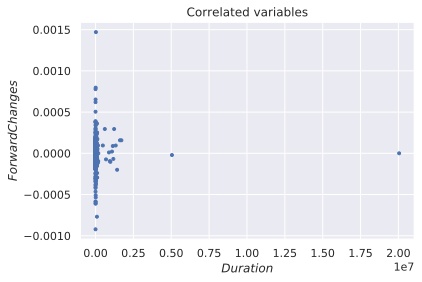

In [65]:
# Plot dummy data
plt.figure()
plt.plot(Y[:,0], Y[:,3], '.')
plt.xlabel(r'$Duration$')
plt.ylabel(r'$ForwardChanges$') #this needs to get shifted a bit
plt.title('Correlated variables')
plt.show()

In [66]:
# Compute Pearson correlation coefficient
rho, pval = pearsonr(Y[:,0], Y[:,3])
print('Correlation coefficient: %0.3g ( p = %0.3g )' % (rho, pval))

Correlation coefficient: 0.00664 ( p = 0.855 )


In [70]:
#STAN code string for a basic pearson correlation
PearsonCorrelation = """
data {
    int<lower=0> N; //number of datapoints
    vector[6] X[N]; //datapoints
}

parameters {
    vector[2] mu;               //mean
    vector<lower=0>[2] sig;     //std dev of each variable
    real<lower=-1,upper=1> rho; //Pearson's rho
}

transformed parameters {
    // Compute the covariance matrix from rho and sigmas
    cov_matrix[2] C;
    C[1,1] = sig[1] * sig[1];
    C[1,2] = rho * sig[1] * sig[2];
    C[2,1] = rho * sig[1] * sig[2];
    C[2,2] = sig[2] * sig[2];
}

model {
    // Model our data as being drawn from multivariate normal 
    // distribution with mean mu and covariance matrix C
    X ~ multi_normal(mu, C);
}
"""

In [71]:
# Compile the Stan model
model_pc = pystan.StanModel(model_code=PearsonCorrelation)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_61a5639b4c192c1e05667dd702e5906d NOW.


# Data for Stan
data = {'N' : Y.shape[0], #number of datapoints
        'X' : Y}          #the data

# Fit the model
fit = model_pc.sampling(data=data, iter=Niters, chains=Nchains, n_jobs=Nchains)

In [ ]:
# Get the MCMC samples (draws from the posterior distribution)
samples = fit.extract()

In [ ]:
# Plot the posterior distribution for the correlation coefficient
plt.figure()
sb.distplot(samples['rho'])
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.show()

In [ ]:
# Create and plot dummy data w/ pooled correlation but no population correlation
N = 10
Ns = 5
X = np.zeros((N*Ns,2))
I = np.zeros(N*Ns, dtype=int) #invididual/group number
plt.figure()
for iS in range(Ns):
    x = np.random.rand(N)
    X1 = x + iS
    X2 = x * (np.floor(Ns/2)-iS) + iS + 0.2*np.random.randn(N)
    X[iS*N:iS*N+N,0] = X1
    X[iS*N:iS*N+N,1] = X2
    I[iS*N:iS*N+N] = iS+1
    plt.plot(X1, X2, '.')
plt.title('Pooled correlation but no population correlation!')
plt.xlabel(r'$X_1$')
plt.ylabel(r'$X_2$')
plt.show()

In [ ]:
N = 20
Ns = 10
# Compute Frequentist estimates of the correlation
rho, pval = pearsonr(Y[:,0], Y[:,1])
print('Pooled correlation coefficient: %0.3g ( p = %0.3g )' % (rho, pval))
for iS in range(Ns):
    rho, pval = pearsonr(Y[iS*N:iS*N+N,0], Y[iS*N:iS*N+N,1])
    print('Individual %d\'s correlation coefficient: %0.3g ( p = %0.3g )' % ((iS+1), rho, pval))

In [73]:
import sys
import time

sys.path.insert(0, '..')

import scipy
import pandas as pd

from pycopula.visualization import pdf_2d, cdf_2d, concentrationFunction
from pycopula.simulation import simulate
from pycopula.copula import ArchimedeanCopula, GaussianCopula, StudentCopula


In [76]:
from copulae.datasets import load_residuals

residuals = load_residuals()
residuals.head()

,A,B,C,D,E,F,G
0,0.730967,0.530860,0.287320,1.193049,0.019040,1.100507,0.278214
1,2.067853,-1.181313,-2.546173,0.381538,-0.038734,0.269874,-0.603940
2,-2.181835,0.380326,0.928632,-0.316861,0.106473,-0.324854,-0.447824
3,0.445040,0.734531,-0.133299,-0.374091,0.173616,-0.319402,-0.775106
4,0.296363,3.024053,0.815791,1.168521,0.134044,1.110424,1.705190


In [77]:
from copulae import GaussianCopula

_, ndim = residuals.shape
g_cop = GaussianCopula(dim=ndim)  # initializing the copulag_c
g_cop.fit(residuals)  # fit the copula to the data

In [78]:

g_cop.summary()

Gaussian Copula Summary
================================================================================
Gaussian Copula with 7 dimensions


Parameters
--------------------------------------------------------------------------------
 Correlation Matrix 
 1.000000  0.191081 -0.365944  0.128203  0.128853  0.110535  0.309972
 0.191081  1.000000  0.512683 -0.027041 -0.082240 -0.032021  0.207898
-0.365944  0.512683  1.000000  0.058283 -0.006468  0.055126  0.010648
 0.128203 -0.027041  0.058283  1.000000  0.624116  0.936115  0.590101
 0.128853 -0.082240 -0.006468  0.624116  1.000000  0.711072  0.416072
 0.110535 -0.032021  0.055126  0.936115  0.711072  1.000000  0.562437
 0.309972  0.207898  0.010648  0.590101  0.416072  0.562437  1.000000



                                  Fit Summary                                   
================================================================================
Log. Likelihood      : -810.930977527587
Variance Estimate    : Not Implemented Yet
Method               : Maximum pseudo-likelihood
Data Points          : 394

Optimization Setup
--------------------------------------------------------------------------------
	bounds         : [(-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0)]
	options        : {'maxiter': 20000, 'ftol': 1e-06, 'iprint': 1, 'disp': False, 'eps': 1.5e-08}
	method         : SLSQP

Results
--------------------------------------------------------------------------------
	x              : [ 0.19108051 -0.36594417  0.12820338  0.12885277  0.11053543  0.30997226
  0.51268309 -0.02704144 -0.08223959 -0.032021    0.20789771  0.05828324
 -0.00646792  0.05512645  0.01064777  0.6241158   0.93611501  0.59010117
  0.71107237  0.41607165  0.56243692]
	fun            : -810.930977527587
	jac            : [-0.00166741 -0.00034106 -0.01108826  0.00120508  0.00207668  0.00140214
 -0.0011975   0.00077307 -0.00851135  0.00973159 -0.00046991  0.00278912
  0.00685911 -0.01133837 -0.00177351  0.02064553 -0.05341008 -0.01230849
 -0.02129733 -0.00406241  0.01491571]
	nit            : 26
	nfev           : 657
	njev           : 26
	status         : 0
	message        : Optimization terminated successfully.
	success        : True

In [82]:
g_cop?